# Capstone 1 Group 4 Notebook

## Importing necessary libraries

In [48]:
# 3rd party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# standard library
import sqlite3
import math

## Loading data

In [69]:
tn_movie_budgets = pd.read_csv('tn.movie_budgets.csv')
tmdb_csv = pd.read_csv('tmdb.movies.csv')

conn = sqlite3.connect('im.db')

Sqlite_df = pd.read_sql("""
select *
from movie_basics
join movie_ratings
using (movie_id)
join movie_akas
using (movie_id)
group by primary_title
;
""", conn)

## Cleaning

### Converting genre IDs to genre names

In [70]:
# Creating dictionary to turn genre IDs into genres
comment = """Action          28
Adventure       12
Animation       16
Comedy          35
Crime           80
Documentary     99
Drama           18
Family          10751
Fantasy         14
History         36
Horror          27
Music           10402
Mystery         9648
Romance         10749
Science Fiction 878
TV Movie        10770
Thriller        53
War             10752
Western         37"""
id_to_genre = {line.split(' ')[-1]:line.split(' ')[0].lower() for line in comment.split('\n')}

# Creating function to transform genre IDs
def convert_ids(line):
    return ','.join(sorted([id_to_genre.get(x.strip(), x.strip()) for x in line[1:-1].split(',')]))

# Transforming and further cleaning genre IDs
Sqlite_df['title'] = Sqlite_df.title.str.lower()

tmdb_csv['genre'] = tmdb_csv.genre_ids.apply(convert_ids)
tmdb_csv.drop(columns=["Unnamed: 0", 'id'], inplace=True)
tmdb_csv['release_date'] = pd.to_datetime(tmdb_csv['release_date'])
tmdb_csv['title'] = tmdb_csv['title'].str.lower()

#Cleaning tn movie budget data
tn_movie_budgets.drop(columns=['id'], inplace=True)
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].str.lower()
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].str.lstrip('$').str.replace(',', '').astype(np.int64)
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].str.lstrip('$').str.replace(',', '').astype(np.int64)
tn_movie_budgets['return_on_budget'] = (tn_movie_budgets['worldwide_gross'] / tn_movie_budgets['production_budget'])
tn_movie_budgets.sort_values(by=['return_on_budget'], ascending=False, inplace=True)

#Merging both datasets
tmdb_csv = tmdb_csv.merge(Sqlite_df, on='title', how='left')
budget_genre = tn_movie_budgets.merge(tmdb_csv, left_on=['movie', 'release_date'], right_on=['title', 'release_date'], how='inner').drop_duplicates()

## Create visualization for return on production budget for genres

### Create custom color palette and set context

In [52]:
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
# https://seaborn.pydata.org/generated/seaborn.color_palette.html
custom_palette = 'blend:#046A38,#86BC25'

def colors_from_values(values, palette_name=custom_palette):
    # normalize the values to range [0, 1]
    normalized = (values - np.min(values)) / (np.max(values) - np.min(values))
    # convert to indices
    indices = np.round((1 - normalized) * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [53]:
# set theme and context
sns.set_theme(style="whitegrid")
sns.set_context('poster', rc={'patch.linewidth': 0.6})

### Top genres for return on production budget

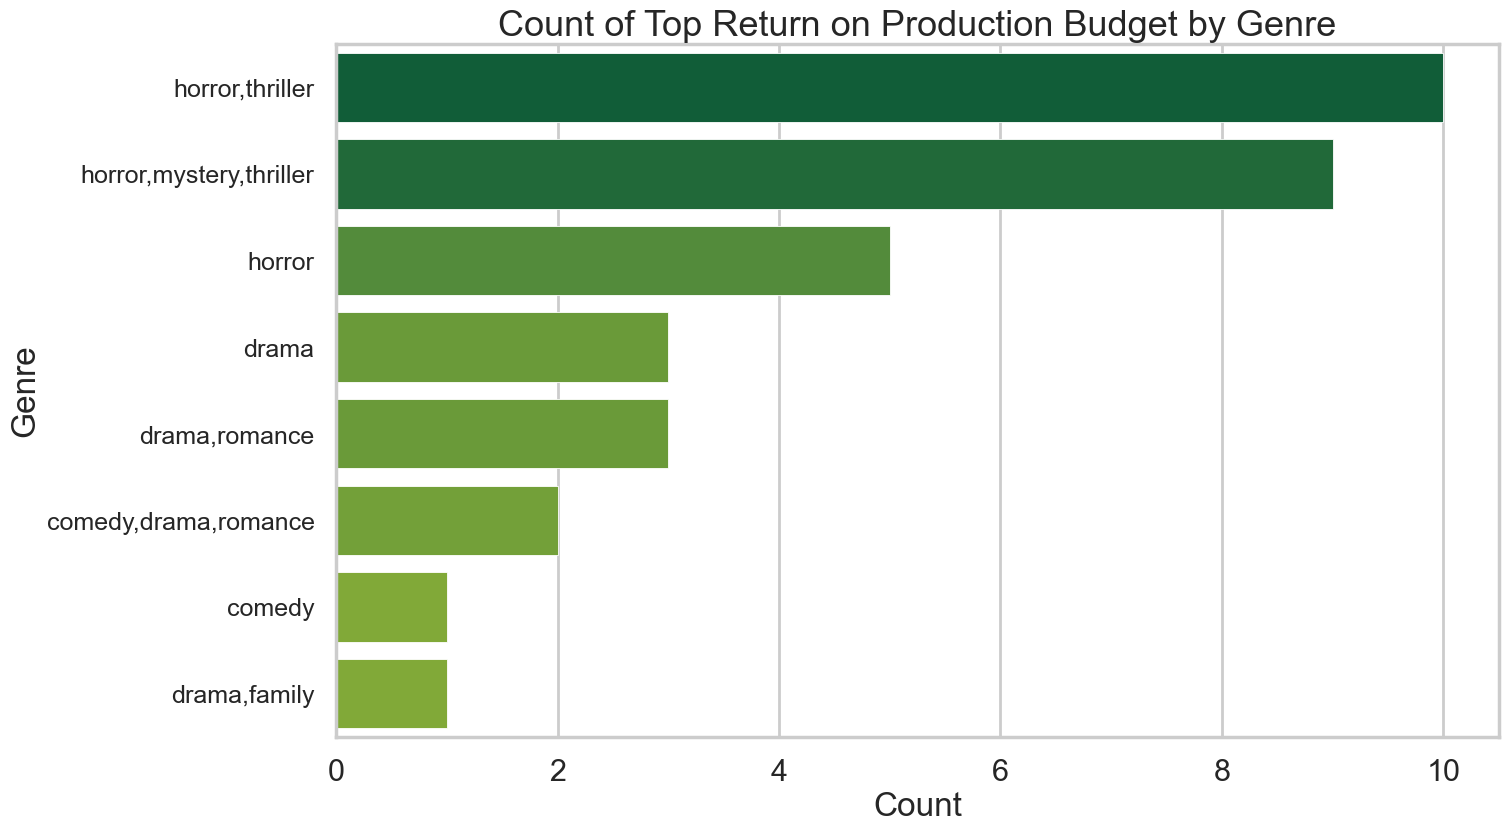

In [95]:
# grab the top 50 return on budget movies and count the genres
genre_combined = budget_genre.iloc[:50]['genre'].value_counts()
genre_combined_df = genre_combined.reset_index()
genre_combined_df.columns = ['genre', 'count']

plt.figure(figsize=(15,9))
sns.barplot(data=genre_combined_df.iloc[:8], x='count', y='genre', orient='h', palette=colors_from_values(genre_combined_df['count']))
plt.title('Count of Top Return on Production Budget by Genre', fontsize=26)
plt.xlabel('Count', fontsize=24)
plt.ylabel('Genre', fontsize=24)
plt.yticks(fontsize=18)
#plt.savefig('images/return_on_production_budget.svg', format='svg', bbox_inches='tight')
None

### Median return on production budget sorted by genres

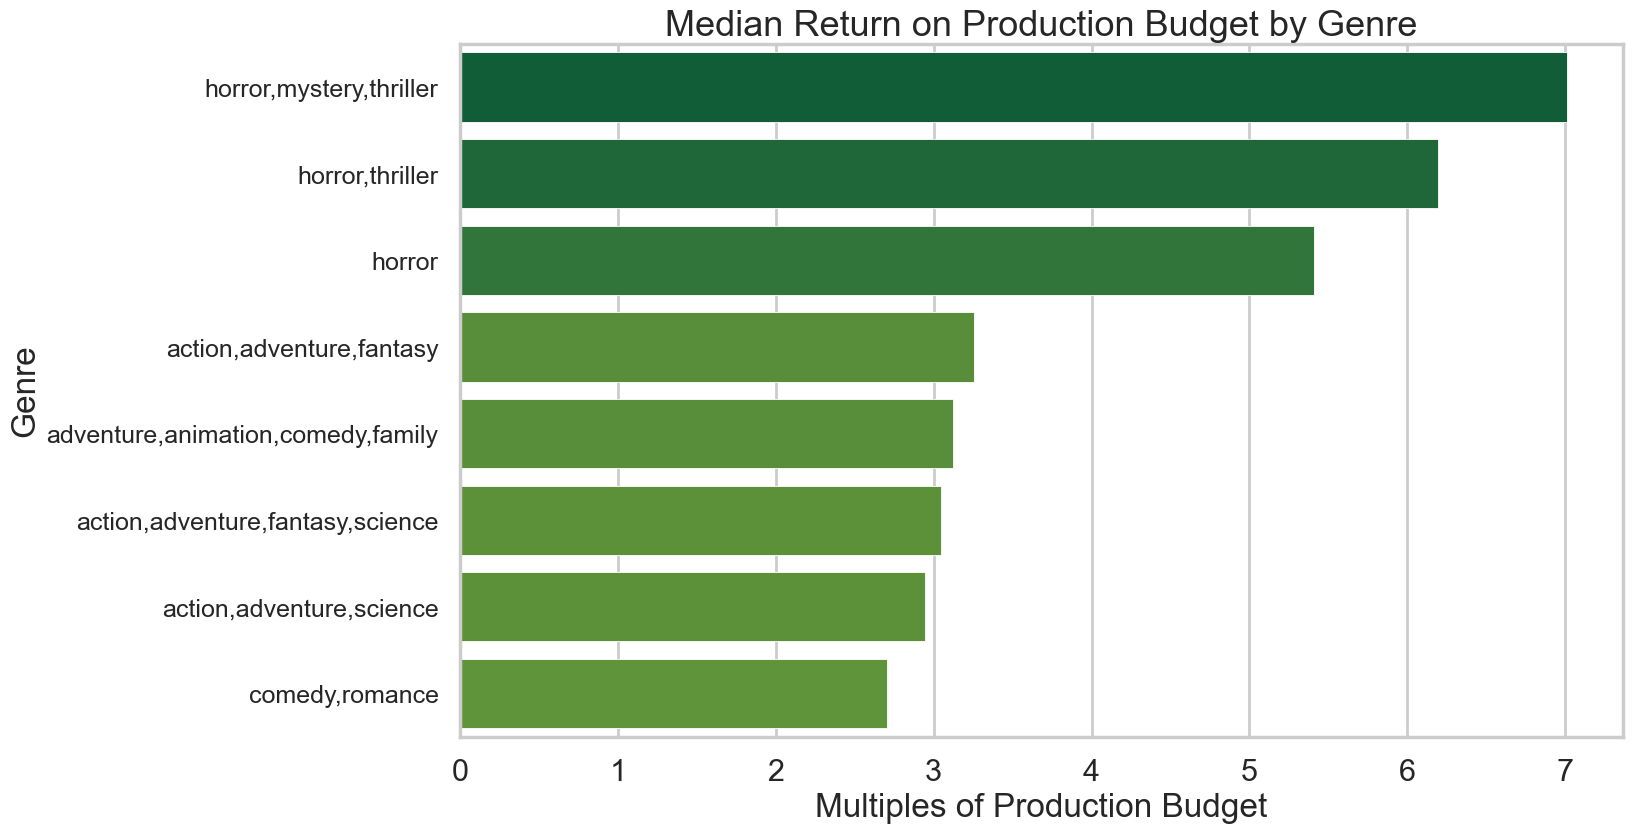

In [96]:
# each genre should have several examples to not be a one off
at_least_10_in_genre = budget_genre.groupby('genre').filter(lambda x: len(x) >= 10)
median_genre = at_least_10_in_genre.groupby('genre')['return_on_budget'].median().sort_values(ascending=False)
median_genre_df = median_genre.reset_index()
median_genre_df.columns = ['genre', 'median return on budget']

# plot 
plt.figure(figsize=(15,9))
sns.barplot(data=median_genre_df.iloc[:8], x='median return on budget', y='genre', palette=colors_from_values(median_genre_df['median return on budget']), orient='h')
plt.title('Median Return on Production Budget by Genre', fontsize=26)
plt.xlabel('Multiples of Production Budget', fontsize=24)
plt.ylabel('Genre', fontsize=24)
plt.yticks(fontsize=18)
#plt.savefig('images/median_return_on_production_budget.svg', format='svg', bbox_inches='tight')
None

## Top combined genres profit

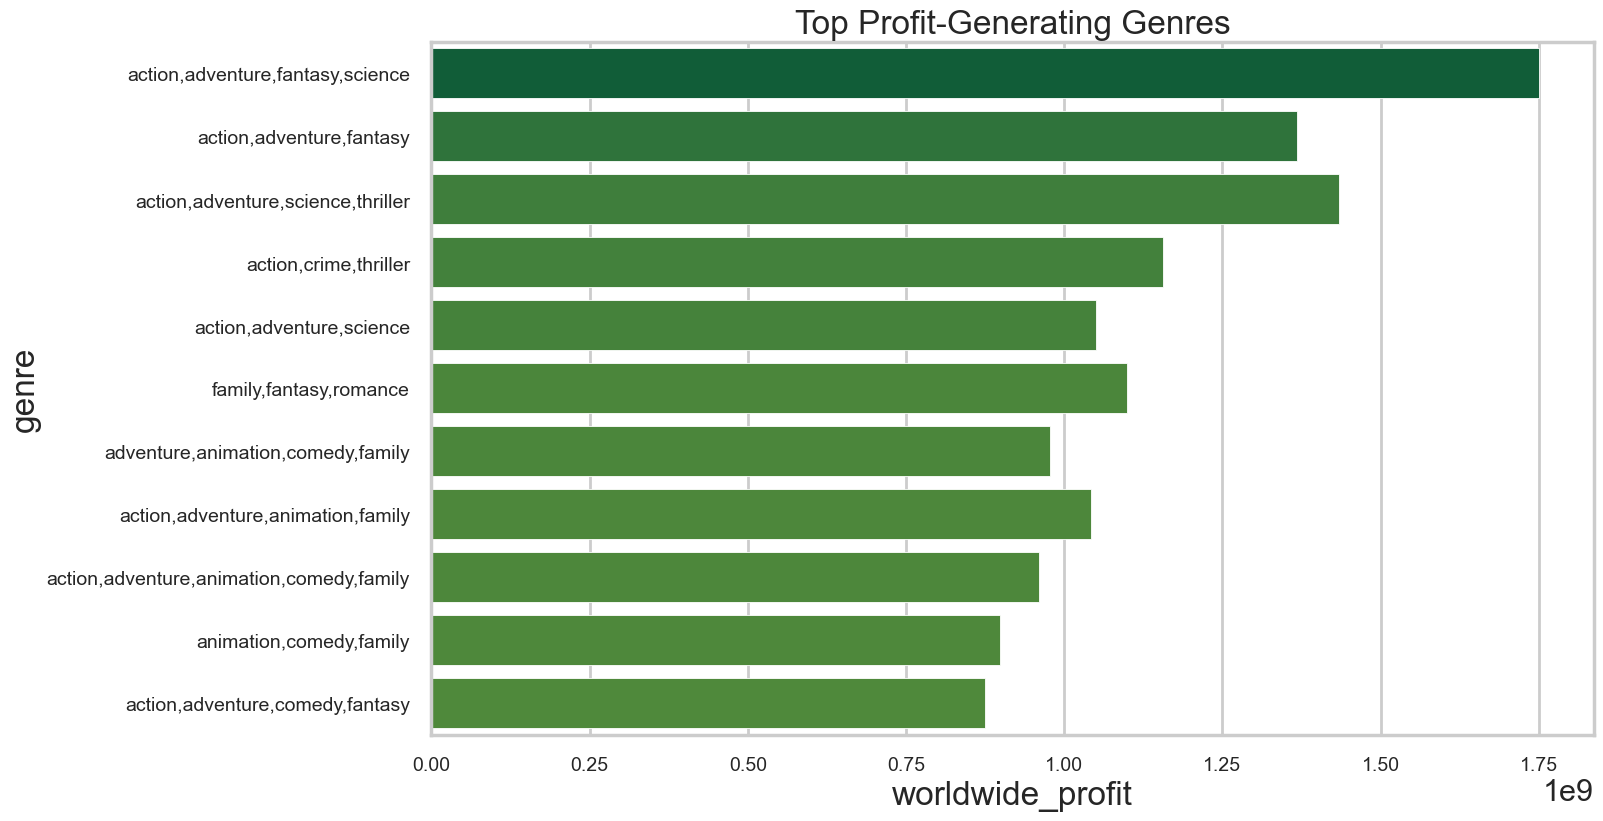

In [77]:
budget_genre['worldwide_profit'] = budget_genre['worldwide_gross'].fillna(0).astype('int64') - budget_genre['production_budget'].fillna(0).astype('int64')

budget_genre_sorted = budget_genre.sort_values('worldwide_profit', ascending= False).drop_duplicates(subset=['movie'])

plt.figure(figsize=(15,9))
sns.barplot(data = budget_genre_sorted.iloc[:20], y='genre', x='worldwide_profit', errorbar=None, palette=colors_from_values(budget_genre_sorted['worldwide_profit']));
plt.title('Top Profit-Generating Genres', fontsize=24)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

## Analyzing correlation between production budget and worldwide profit

In [83]:
prod_bud_cor = budget_genre.production_budget.fillna(budget_genre.production_budget.mean())
world_prof_cor = budget_genre.worldwide_profit.fillna(budget_genre.worldwide_profit.mean())

cor_value = prod_bud_cor.astype('int64').corr(world_prof_cor.astype('int64'))
cor_value_strength = None
if cor_value >= .5:
    cor_value_strength = 'strong'
elif cor_value >= .3:
    cor_value_strength = 'moderate'
else:
    cor_value_strength = 'weak'
    

print(f'There is a {cor_value_strength} correlation between the production budget and worldwide profit with a value of {round(cor_value, 4)}.')

There is a strong correlation between the production budget and worldwide profit with a value of 0.6838.


## Determining 95% confidence interval for production budget

In [84]:
prod_budget_std = budget_genre_sorted.production_budget.astype('int64').std()
prod_budget_mean = budget_genre_sorted.production_budget.astype('int64').mean()


x_hat = prod_budget_mean
z = stats.norm.ppf(q=.95)
pop_stdev = budget_genre.production_budget.dropna().astype('int64').std()
sample_size = len(budget_genre_sorted)
moe = (z * pop_stdev)/(math.sqrt(sample_size))
conf = (round(x_hat - moe, 2), round(x_hat + moe, 2))
print(f'We are 95% confident that the true mean of production budgets of the top 10 profiting movies is contained within the range ${round(conf[0], 2)} and ${round(conf[1], 2)}. Further, due to the {cor_value_strength} correlation between profit and production budgets of {round(cor_value, 4)} we \nrecommend that the production budget for a new movie should be within this range.')


We are 95% confident that the true mean of production budgets of the top 10 profiting movies is contained within the range $42774346.53 and $47899452.12. Further, due to the strong correlation between profit and production budgets of 0.6838 we 
recommend that the production budget for a new movie should be within this range.


## Closing connection

In [85]:
conn.close()